## Testowanie różnych modeli dla danych EEG

In [1]:
import glob
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score

#import scikitplot as skplt
#from scikitplot.estimators import plot_learning_curve

from sklearn import metrics
from sklearn.inspection import permutation_importance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.metrics import classification_report

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
# funkcja do sortowania danych
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# KLASYFIKACJA

In [6]:
def data_to_model(fold):
    # ścieżka do folderów w którym są pliki .tar
    path_to_name='_coh/fold={}'.format(fold)

    # tworzenie listy nazw z plików .tar
    name_fold=[x.split('/')[-1].split('.')[0] for x in sorted(glob.glob('{}/*.tar'.format(path_to_name)),key=numericalSort)]
    
    # wczytujemy zbiór danych
    results=pd.read_csv('up_coh/up_fold={}/fold_{}.csv'.format(fold,fold))
    
    # tworzymy zbiór danych tylko dla pacjentów zdrowych gdzie klasa =0
    results1=results[results['class']==0]
    
    # tworzenie listy z nazwami wszytskich plików .npy z wszytskich folderów
    # tworznie kluczy do słownika
    npy_files=[]
    for n_fold in name_fold:
        npy = [x for x in sorted(glob.glob('up_coh/up_fold={}/{}/*.npy'.format(fold,n_fold)),key=numericalSort)]
        npy_files.extend(npy)
    
    # tworznie wartości do słownika
    npy_v=['{}.data.npy'.format(x) for x in results['num'] ]
    
    # tworzenie słownika
    dict_npy = dict(zip(npy_files,npy_v))
    # tworzenie listy .npy gdzie klasa =0
    npy_1=['{}.data.npy'.format(x) for x in results1['num'] ]
    
    # tworzenie listy ścieżek do plików .npy gdzie klasa =0 w celu pobrania odpowiednich plików .npy z folderów
    list_name=[]
    for key, value in dict_npy.items():
        if value in npy_1:
            list_name.append(key)
    
    # przygotowanie macierzy cech
    X_train=[]
    for x in list_name:
        X_train.append(np.load('{}'.format(x)))
    X=np.array(X_train)
    
    # przygotowanie targetu
    y=results1['age_int']
    
    return X,y

In [7]:
# ładowanie danych dla wszytskich 'fold'ów' uwzględniając tylko pacjentów zdrowych
X_fold1,y_fold1=data_to_model(1)
X_fold2,y_fold2=data_to_model(2)
X_fold3,y_fold3=data_to_model(3)
X_fold4,y_fold4=data_to_model(4)
X_fold5,y_fold5=data_to_model(5)
X_fold6,y_fold6=data_to_model(6)

In [20]:
X_all=np.concatenate((X_fold1, X_fold2, X_fold3, X_fold4, X_fold5, X_fold6))

In [21]:
y_all=pd.concat((y_fold1, y_fold2, y_fold3, y_fold4, y_fold5, y_fold6))

In [22]:
X_all.shape, y_all.shape

((21561, 1653), (21561,))

### Sprawdzenie rozkładu danych 'age'

'age' został podzielony na 10 klas - odpowiadjacych co 10 lat

In [11]:
# funkcja do tworzenia histogramów
def check_data(y):
    unique, counts_train = np.unique(y, return_counts=True)
    
    plt.figure(figsize=(8, 5))
    plt.bar(y_all.unique(), counts_train)
    plt.ylabel('value_counts')
    plt.title('age_int')
    plt.xticks(rotation='vertical')
    plt.show()

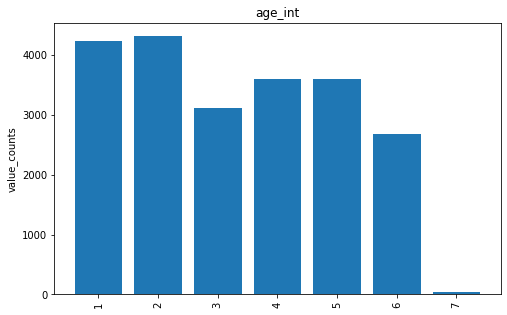

In [12]:
check_data(y_all)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2022)

In [24]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (15092, 1653) (15092,)
Test: (6469, 1653) (6469,)


### Dane treningowe

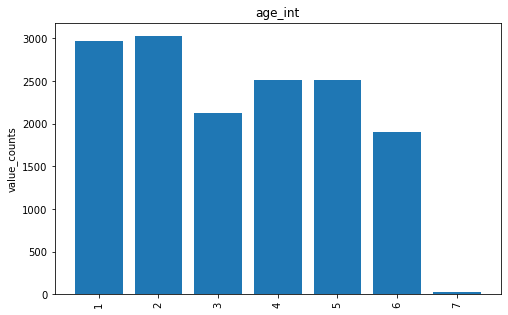

In [11]:
check_data(y_train)

### Dane testowe

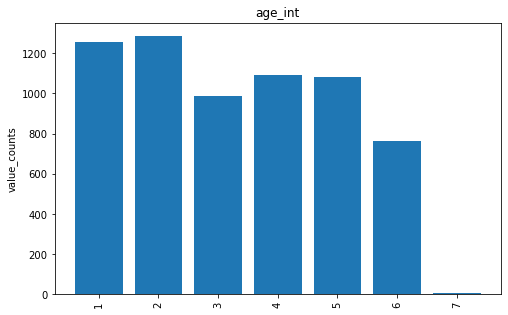

In [12]:
check_data(y_test)

## model Random Forest Classifier

In [25]:
# trenowanie modelu - pacjenci zdrowi
model = RandomForestClassifier(random_state=2022, max_depth=20, n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
print(metrics.accuracy_score(y_test, y_pred))

0.41304683876951614


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.55      0.57       985
           2       0.40      0.55      0.46      1287
           3       0.35      0.36      0.35      1254
           4       0.35      0.24      0.28      1082
           5       0.39      0.46      0.43      1092
           6       0.46      0.28      0.35       761
           7       0.00      0.00      0.00         8

    accuracy                           0.41      6469
   macro avg       0.36      0.35      0.35      6469
weighted avg       0.42      0.41      0.41      6469



/home/anna_s/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


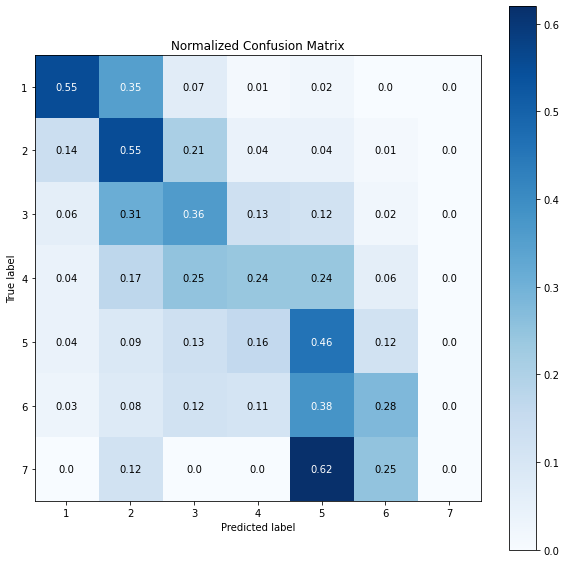

In [48]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10 ,10));

In [42]:
print( pd.Series(y_pred).value_counts() )

2    1785
5    1289
3    1285
1     911
4     745
6     454
dtype: int64


Sprawdzenie ważności cech

/home/anna_s/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


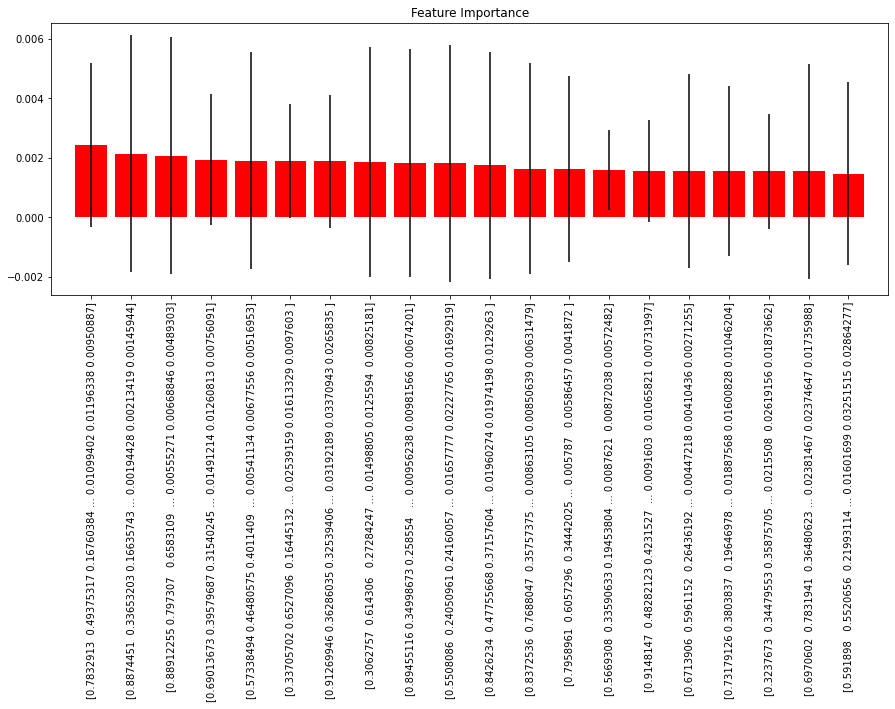

In [50]:
skplt.estimators.plot_feature_importances(model, feature_names=X_train, x_tick_rotation=90, figsize=(15, 5));

## model XGBClassifier

In [27]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
print(metrics.accuracy_score(y_test, y_pred))

0.4125830885762869


Sprawdzenie dla modelu XGBClassifier parametr n_estimators

In [13]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=60)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/home/anna_s/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:05:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
print(metrics.accuracy_score(y_test, y_pred))

0.420312258463441


In [15]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=90)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[08:27:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
print(metrics.accuracy_score(y_test, y_pred))

0.42618642757767816


In [28]:
# trenowanie modelu - pacjenci zdrowi
model = xgb.XGBClassifier(random_state=2022, max_depth=20, n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
print(metrics.accuracy_score(y_test, y_pred))

0.43468851445354767


### Optymalizacja hiperparametrów modelu - Baysian optimalization

In [68]:
# https://github.com/MamczurMiroslaw/gradient_boosting_example/blob/master/Hyperparameters_optimalization_example.ipynb

In [28]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred, average='macro',multi_class='ovo')
    Gini_index = 2*score_test - 1
    
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d

def calculating_metrics(X_train, X_val, X_oot, y_train, y_val, y_oot):
    test = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    val = create_measures(y_val,model.predict_proba(X_val)[:, 1])
    oot = create_measures(y_oot,model.predict_proba(X_oot)[:, 1]) 

    measures =  pd.concat([test,val,oot]).set_index([pd.Index(['TRAIN', 'VAL', 'OOT'])]) 
    
    return measures

In [ ]:
#model = xgb.XGBClassifier(tree_method='gpu_hist')
#model.fit(X_train, y_train)  

In [20]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2022)

In [ ]:
# https://stackoverflow.com/questions/63303682/sklearn-multiclass-roc-auc-score
#measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val)
#measures

# REGRESJA

Sprawdzenie czy wiek bez podziału na klasy poprawi wynik modelu

In [78]:
def data_to_model(fold):
    # ścieżka do folderów w którym są pliki .tar
    path_to_name='_coh/fold={}'.format(fold)

    # tworzenie listy nazw z plików .tar
    name_fold=[x.split('/')[-1].split('.')[0] for x in sorted(glob.glob('{}/*.tar'.format(path_to_name)),key=numericalSort)]
    
    # wczytujemy zbiór danych
    results=pd.read_csv('up_coh/up_fold={}/fold_{}.csv'.format(fold,fold))
    
    # tworzymy zbiór danych tylko dla pacjentów zdrowych gdzie klasa =0
    results1=results[results['class']==0]
    
    # tworzenie listy z nazwami wszytskich plików .npy z wszytskich folderów
    # tworznie kluczy do słownika
    npy_files=[]
    for n_fold in name_fold:
        npy = [x for x in sorted(glob.glob('up_coh/up_fold={}/{}/*.npy'.format(fold,n_fold)),key=numericalSort)]
        npy_files.extend(npy)
    
    # tworznie wartości do słownika
    npy_v=['{}.data.npy'.format(x) for x in results['num'] ]
    
    # tworzenie słownika
    dict_npy = dict(zip(npy_files,npy_v))
    # tworzenie listy .npy gdzie klasa =0
    npy_1=['{}.data.npy'.format(x) for x in results1['num'] ]
    
    # tworzenie listy ścieżek do plików .npy gdzie klasa =0 w celu pobrania odpowiednich plików .npy z folderów
    list_name=[]
    for key, value in dict_npy.items():
        if value in npy_1:
            list_name.append(key)
    
    # przygotowanie macierzy cech
    X_train=[]
    for x in list_name:
        X_train.append(np.load('{}'.format(x)))
    X=np.array(X_train)
    
    # przygotowanie targetu
    y=results1['age']
    
    return X,y,results1

In [79]:
# ładowanie danych dla wszytskich 'fold'ów' uwzględniając tylko pacjentów zdrowych
X_fold1,y_fold1, df_fold1=data_to_model(1)
X_fold2,y_fold2, df_fold2=data_to_model(2)
X_fold3,y_fold3, df_fold3=data_to_model(3)
X_fold4,y_fold4, df_fold4=data_to_model(4)
X_fold5,y_fold5, df_fold5=data_to_model(5)
X_fold6,y_fold6, df_fold6=data_to_model(6)

In [80]:
X_all=np.concatenate((X_fold1, X_fold2, X_fold3, X_fold4, X_fold5, X_fold6))

In [81]:
y_all=pd.concat((y_fold1, y_fold2, y_fold3, y_fold4, y_fold5, y_fold6))

In [82]:
df_all=pd.concat((df_fold1, df_fold2, df_fold3, df_fold4, df_fold5, df_fold6))

In [83]:
#df_all.head(5)

In [84]:
X_all.shape, y_all.shape

((21561, 1653), (21561,))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=2022)

In [86]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (15092, 1653) (15092,)
Test: (6469, 1653) (6469,)


### Sprawdzenie rozkładu danych 'age'

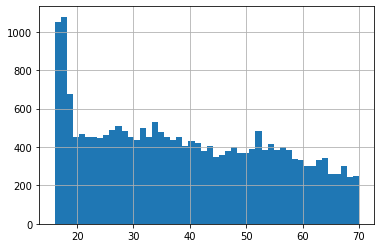

In [87]:
y_all.hist(bins=50);

In [88]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#import scikitplot as skplt
#from scikitplot.estimators import plot_learning_curve


import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
    
import matplotlib.pyplot as plt
%matplotlib inline

### model DecisionTreeRegressor

CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
Wall time: 12.8 s
CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 12.7 ms


0.2868627800425567

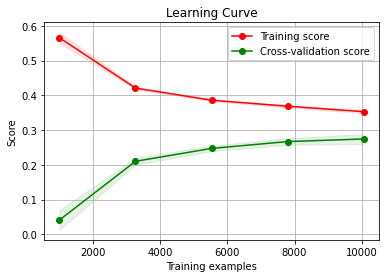

In [57]:
model = DecisionTreeRegressor(random_state=2022, max_depth=5)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

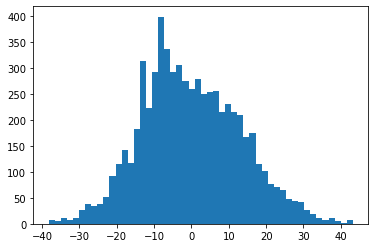

In [58]:
plt.hist(y_test - y_pred, bins=50);

### model RandomForestRegressor

CPU times: user 1min 16s, sys: 3.9 ms, total: 1min 16s
Wall time: 1min 16s
CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 14 ms


0.35567632118411385

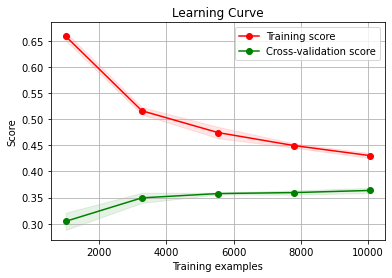

In [59]:
model = RandomForestRegressor(random_state=2022, n_estimators=10, max_depth=5)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

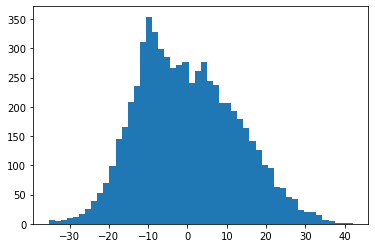

In [60]:
plt.hist(y_test - y_pred, bins=50);

### model XGBRegressor

In [61]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, random_state=2022)
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

CPU times: user 18min 35s, sys: 767 ms, total: 18min 36s
Wall time: 2min 20s
CPU times: user 388 ms, sys: 32 ms, total: 420 ms
Wall time: 86.3 ms


0.5412161105251329

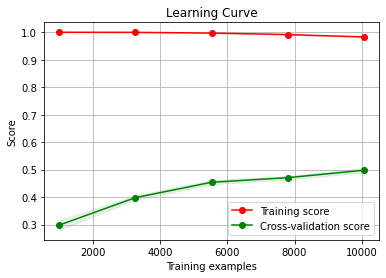

In [62]:
%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)plt.hist(y_test - y_pred, bins=50);

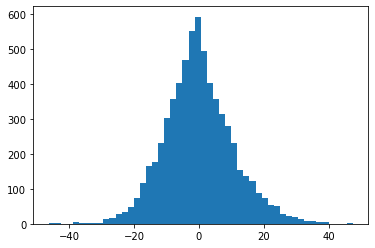

In [63]:
plt.hist(y_test - y_pred, bins=50);

### model CatBoostRegressor

CPU times: user 1min 7s, sys: 1.2 s, total: 1min 8s
Wall time: 11.9 s
CPU times: user 413 ms, sys: 1e+03 ns, total: 413 ms
Wall time: 382 ms


0.5420487025504264

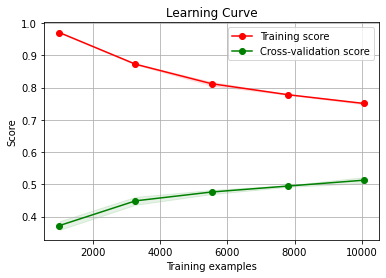

In [64]:
model = ctb.CatBoostRegressor(n_estimators=100, depth=5, random_state=2022, verbose=False)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

plot_learning_curve(model, X, y, cv=3, random_state=2022, shuffle=True)

r2_score(y_test, y_pred)

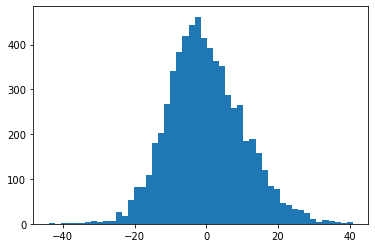

In [65]:
plt.hist(y_test - y_pred, bins=50);

### Zapisanie X_train do DataFrame

In [89]:
type(X_test)

numpy.ndarray

In [90]:
df_X_train = pd.DataFrame.from_records(X_train)

In [91]:
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Columns: 1653 entries, 0 to 1652
dtypes: float32(1653)
memory usage: 95.2 MB


In [92]:
df_X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652
0,0.948392,0.807233,0.634927,0.795152,0.689951,0.808429,0.360581,0.324411,0.274222,0.485078,...,0.036672,0.041285,0.045557,0.045326,0.062304,0.065491,0.038242,0.014110,0.018287,0.013729
1,0.746620,0.575926,0.214289,0.517099,0.307934,0.401059,0.521206,0.516610,0.191877,0.430831,...,0.036164,0.023736,0.016015,0.011243,0.011759,0.008217,0.004201,0.002672,0.003413,0.002757


#### sprawdzenie rozkładu dla poszczegolnych cech

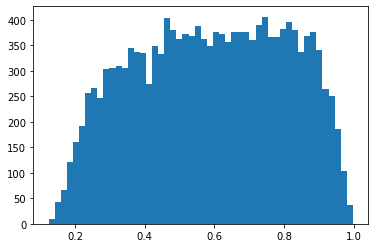

In [24]:
plt.hist(df_X_train[0], bins=50);

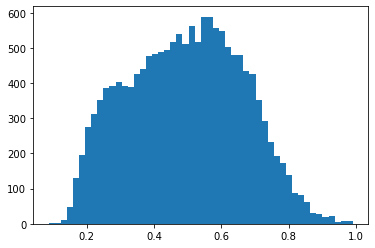

In [27]:
plt.hist(df_X_train[1], bins=50);

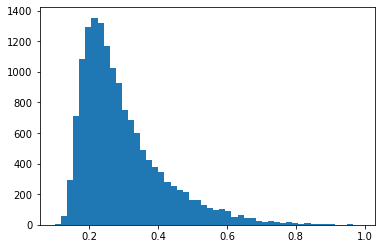

In [28]:
plt.hist(df_X_train[2], bins=50);

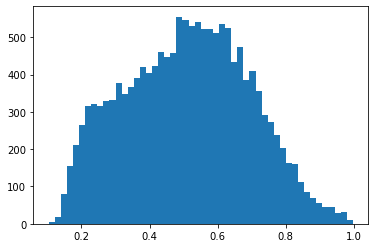

In [29]:
plt.hist(df_X_train[3], bins=50);

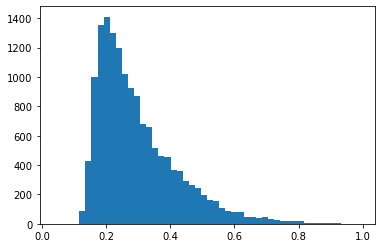

In [30]:
plt.hist(df_X_train[4], bins=50);

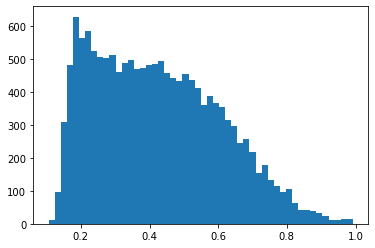

In [31]:
plt.hist(df_X_train[5], bins=50);

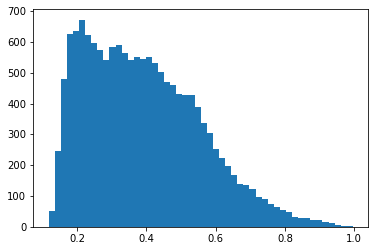

In [32]:
plt.hist(df_X_train[6], bins=50);

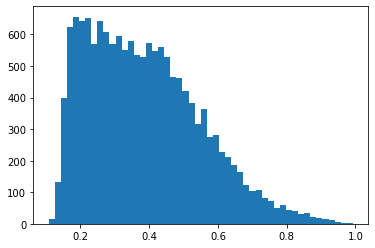

In [36]:
plt.hist(df_X_train[7], bins=50);

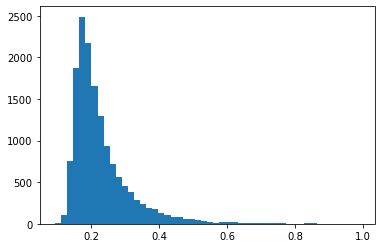

In [44]:
plt.hist(df_X_train[8], bins=50);

#### Sprawdzenie rozkładu dla większej ilosći cech jednocześnie

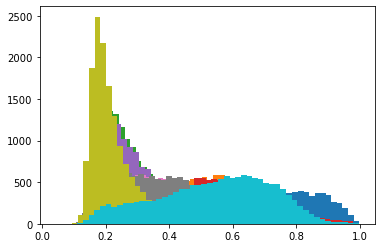

In [25]:
for x in range(10):
    plt.hist(df_X_train[x], bins=50);

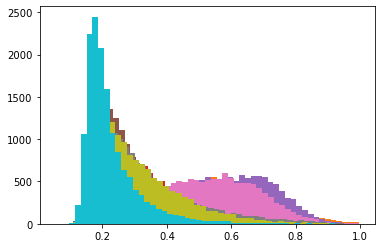

In [26]:
for x in range(10,20):
    plt.hist(df_X_train[x], bins=50);

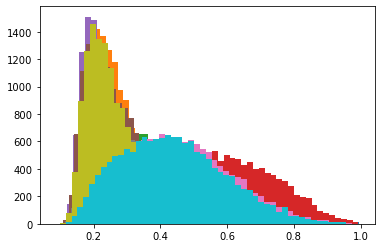

In [45]:
for x in range(20,30):
    plt.hist(df_X_train[x], bins=50);

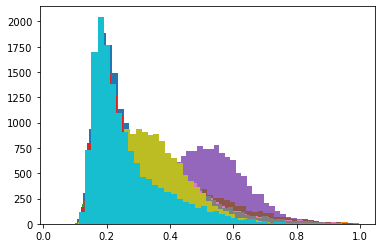

In [46]:
for x in range(30,40):
    plt.hist(df_X_train[x], bins=50);

### Sprawdzenie czy optymalizacja hiperparametrów modelu poprawi wyniki

In [34]:
# https://www.kaggle.com/code/sumitdewang/sumit-dewang-bike-sharing-rental-demand

In [130]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge

# For Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import BernoulliNB, GaussianNB,MultinomialNB
from xgboost import XGBRegressor,XGBRFRegressor

#Evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


### model Linear Regression

In [18]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [19]:
y_pred = lr_model.predict(X_test)
y_pred[5:10]

array([21.049217, 34.381737, 53.40461 , 28.975769, 30.96106 ],
      dtype=float32)

In [20]:
y_test[5:10]

7241    22.073922
4188    33.416667
1192    50.500000
3861    19.083333
2817    17.666667
Name: age, dtype: float64

In [21]:
# Training Data Evaluation

y_pred_train = lr_model.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2 = r2_score(y_train, y_pred_train)
print('R-Squared :',r2)

MSE : 88.02432411257897
RMSE : 9.382127909625778
MAE : 7.306081001375373
R-Squared : 0.6415078265962636


In [22]:
# Testing Data Evaluation
y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 115.03936567356429
RMSE : 10.725640571712455
MAE : 8.367084280208474
R-Squared : 0.532697959058093


Regularization

In [23]:
ridge_model = Ridge(alpha=0.08) #Alpha = Lambda >> Hyperparameter 
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.08)

In [24]:
# Training Data Accuracy
y_pred_train = ridge_model.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Testing MSE is:",mse)
r2 = r2_score(y_train,y_pred_train)
print("Testing R2 score is:",r2)

Testing MSE is: 88.48618271007449
Testing R2 score is: 0.6396268386524129


In [25]:
# Testing data

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print("Testing MSE is:",mse)
r2 = r2_score(y_test,y_pred)
print("Testing R2 score is:",r2)

Testing MSE is: 112.78513880403169
Testing R2 score is: 0.541854866441152


### model Decision Tree

In [30]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)

DecisionTreeRegressor()

In [31]:
# Training Data Evaluation

y_pred_train = dt_reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2 = r2_score(y_train, y_pred_train)
print('R-Squared :',r2)

MSE : 0.26759213758071243
RMSE : 0.5172930867319923
MAE : 0.019932961628787806
R-Squared : 0.9989101911550679


In [32]:
# Testing Data Evaluation
y_pred = dt_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 263.7221576123653
RMSE : 16.239524550071202
MAE : 12.10149951009795
R-Squared : -0.07126722902455374


Hyperparameter Tunning for Decision Tree

In [34]:
dt_reg = DecisionTreeRegressor()

hyperparameters ={ "criterion" :['mse','mae'],
     'max_depth': np.arange(3,14),
     'min_samples_split' : np.arange(2,20),
     'min_samples_leaf':np.arange(2,15)}

#gscv_dt_reg = RandomizedSearchCV(dt_reg,hyperparameters, cv = 5,n_jobs=-1)
#gscv_dt_reg.fit(X_train, y_train)
#gscv_dt_reg.best_estimator_

In [ ]:
dt_reg = gscv_dt_reg.best_estimator_
dt_reg.fit(X_train, y_train)

### model XGBoostRegressor

In [26]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [27]:
# Training Data Evaluation
y_pred_train = xgb_reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2_value = r2_score(y_train, y_pred_train)
print("R-Squared Value is :",r2_value)

MSE : 9.248963513869722
RMSE : 3.0412108631053063
MAE : 2.2557994143602156
R-Squared Value is : 0.9623322182221086


In [28]:
# Testing Data Evaluation
y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 112.94238629914418
RMSE : 10.627435546694421
MAE : 8.143869198879969
R-Squared : 0.5412161105251329


In [29]:
y_pred[950:955]

array([41.197613, 34.226883, 60.85134 , 41.656998, 35.986813],
      dtype=float32)

In [30]:
y_test[950:955]

2793    40.583333
1185    47.000000
5882    53.500000
1343    29.666667
1385    21.750000
Name: age, dtype: float64

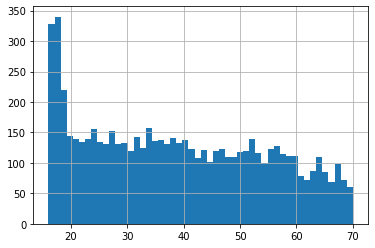

In [31]:
y_test.hist(bins=50);

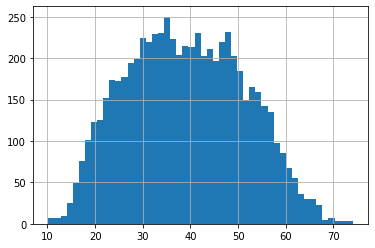

In [32]:
pd.Series(y_pred).hist(bins=50);

Hyper parameter tuning XGBoost

In [14]:
space ={
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('x_max_depth', 1, 9, 1),
    'n_estimators': hp.quniform ('x_n_estimators', 100, 1000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 0, 100, 1),
    'gamma': hp.loguniform ('x_gamma', 0.0, 2.0),
    'subsample': hp.uniform ('x_subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('x_colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.loguniform ('x_reg_lambda', 0.0, 2.0),
}

In [15]:
def objective(space):
    xgb_params = {
        # ogólne
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'gamma': space['gamma'],
        'seed': 2022,
        # do walki z overfiting
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'colsample_bylevel': space['colsample_bylevel'],
        # regularyzacja
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        # pozostałe
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_squared_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }

In [16]:
trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|███████████████████████████████████████████████████████████████████████████| 30/30 [2:22:18<00:00, 284.61s/trial, best loss: 93.20454172680371]
The best params:  {'x_colsample_bylevel': 0.8809205445237085, 'x_colsample_bytree': 0.7743769616778238, 'x_gamma': 1.5449434645908333, 'x_learning_rate': 0.04550027852677481, 'x_max_depth': 6.0, 'x_min_child_weight': 82.0, 'x_n_estimators': 950.0, 'x_reg_alpha': 3.2712584573057533, 'x_reg_lambda': 2.571329345063856, 'x_subsample': 0.6133804632546268}


In [18]:
best_params=trials.best_trial

In [19]:
best_params

{'state': 2,
 'tid': 24,
 'spec': None,
 'result': {'loss': 93.20454172680371, 'status': 'ok'},
 'misc': {'tid': 24,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bylevel': [24],
   'x_colsample_bytree': [24],
   'x_gamma': [24],
   'x_learning_rate': [24],
   'x_max_depth': [24],
   'x_min_child_weight': [24],
   'x_n_estimators': [24],
   'x_reg_alpha': [24],
   'x_reg_lambda': [24],
   'x_subsample': [24]},
  'vals': {'x_colsample_bylevel': [0.8809205445237085],
   'x_colsample_bytree': [0.7743769616778238],
   'x_gamma': [1.5449434645908333],
   'x_learning_rate': [0.04550027852677481],
   'x_max_depth': [6.0],
   'x_min_child_weight': [82.0],
   'x_n_estimators': [950.0],
   'x_reg_alpha': [3.2712584573057533],
   'x_reg_lambda': [2.571329345063856],
   'x_subsample': [0.6133804632546268]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 12, 21, 10, 36, 44, 248000),
 'refresh_time': datetime.da

In [24]:
xgb_reg = XGBRegressor(**{'x_colsample_bylevel': 0.8809205445237085,
   'x_colsample_bytree': 0.7743769616778238,
   'x_gamma': 1.5449434645908333,
   'x_learning_rate': 0.04550027852677481,
   'x_max_depth': 6.0,
   'x_min_child_weight': 82.0,
   'x_n_estimators': 950.0,
   'x_reg_alpha': 3.2712584573057533,
   'x_reg_lambda': 2.571329345063856,
   'x_subsample': 0.6133804632546268})
xgb_reg.fit(X_train,y_train)

[12:43:25] WARNING: ../src/learner.cc:767: 
Parameters: { "x_colsample_bylevel", "x_colsample_bytree", "x_gamma", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_subsample" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [25]:
# Training Data Evaluation
y_pred_train = xgb_reg.predict(X_train)

mse = mean_squared_error(y_train, y_pred_train)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE :",mae)

r2_value = r2_score(y_train, y_pred_train)
print("R-Squared Value is :",r2_value)

MSE : 9.248963513869722
RMSE : 3.0412108631053063
MAE : 2.2557994143602156
R-Squared Value is : 0.9623322182221086


In [26]:
# Testing Data Evaluation
y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 112.94238629914418
RMSE : 10.627435546694421
MAE : 8.143869198879969
R-Squared : 0.5412161105251329


### Badanie cech

In [93]:
df_X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652
0,0.948392,0.807233,0.634927,0.795152,0.689951,0.808429,0.360581,0.324411,0.274222,0.485078,...,0.036672,0.041285,0.045557,0.045326,0.062304,0.065491,0.038242,0.014110,0.018287,0.013729
1,0.746620,0.575926,0.214289,0.517099,0.307934,0.401059,0.521206,0.516610,0.191877,0.430831,...,0.036164,0.023736,0.016015,0.011243,0.011759,0.008217,0.004201,0.002672,0.003413,0.002757
2,0.263161,0.330337,0.204795,0.338505,0.189303,0.249672,0.302185,0.193063,0.155043,0.248955,...,0.079305,0.154645,0.149967,0.050630,0.037759,0.033869,0.030550,0.022065,0.024785,0.018057
3,0.868039,0.547711,0.237430,0.635282,0.440689,0.450580,0.503887,0.498472,0.187754,0.762667,...,0.126880,0.556072,0.487204,0.115022,0.123168,0.067872,0.032030,0.013702,0.012321,0.007392
4,0.648348,0.581971,0.195540,0.197477,0.177909,0.185853,0.221986,0.203278,0.178148,0.704896,...,0.113671,0.627763,0.506492,0.031921,0.046025,0.042879,0.021318,0.008444,0.009730,0.007271


In [94]:
corr_=df_X_train.corr().abs()

In [95]:
corr_

,0,1,2,3,4,5,6,7,8,9,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652
0,1.000000,0.205268,0.323254,0.098657,0.454400,0.143514,0.319020,0.343343,0.166918,0.271784,...,0.099010,0.013987,0.029139,0.152129,0.176473,0.185391,0.187284,0.175161,0.129718,0.108374
1,0.205268,1.000000,0.423848,0.268689,0.147885,0.473327,0.080524,0.051301,0.112037,0.087679,...,0.010441,0.032471,0.027066,0.051456,0.060571,0.066702,0.075573,0.075674,0.059655,0.051901
2,0.323254,0.423848,1.000000,0.204971,0.419127,0.334606,0.198473,0.212200,0.393269,0.079867,...,0.090304,0.078152,0.046505,0.116278,0.126799,0.126082,0.112062,0.099386,0.072001,0.055462
3,0.098657,0.268689,0.204971,1.000000,0.547861,0.547564,0.551365,0.464944,0.128318,0.282078,...,0.011818,0.050531,0.049662,0.025726,0.028633,0.034214,0.037450,0.044722,0.061898,0.067312
4,0.454400,0.147885,0.419127,0.547861,1.000000,0.374215,0.494625,0.548281,0.320674,0.295392,...,0.085053,0.121125,0.103107,0.136225,0.140998,0.146138,0.133514,0.117428,0.104973,0.096481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648,0.185391,0.066702,0.126082,0.034214,0.146138,0.099462,0.112110,0.100679,0.115192,0.094344,...,0.260793,0.204565,0.034375,0.654869,0.875456,1.000000,0.882643,0.700158,0.572483,0.502298
1649,0.187284,0.075573,0.112062,0.037450,0.133514,0.099024,0.102800,0.087014,0.093601,0.106831,...,0.329894,0.282726,0.011134,0.547805,0.685074,0.882643,1.000000,0.909778,0.715323,0.638793
1650,0.175161,0.075674,0.099386,0.044722,0.117428,0.094317,0.091276,0.071293,0.066605,0.099585,...,0.274986,0.343473,0.113848,0.475177,0.561310,0.700158,0.909778,1.000000,0.846110,0.770458
1651,0.129718,0.059655,0.072001,0.061898,0.104973,0.090484,0.082654,0.063481,0.041093,0.078025,...,0.262788,0.351870,0.147620,0.384273,0.460036,0.572483,0.715323,0.846110,1.000000,0.982088


In [96]:
_corr=corr_.unstack().sort_values(ascending=False).drop_duplicates()

In [97]:
_corr.head(20)

0    0      1.000000
171  0      0.999217
290  119    0.998845
275  104    0.998812
174  3      0.998808
244  73     0.998790
339  168    0.998763
23   194    0.998726
302  131    0.998703
169  340    0.998678
11   182    0.998675
149  320    0.998674
276  105    0.998657
61   232    0.998631
187  16     0.998629
9    180    0.998624
14   185    0.998623
1    172    0.998608
91   262    0.998597
250  79     0.998585
dtype: float64

In [98]:
len(_corr)

1365379

In [99]:
df_X_train[[0,171,174,3]]

,0,171,174,3
0,0.948392,0.946291,0.779014,0.795152
1,0.746620,0.753127,0.517309,0.517099
2,0.263161,0.279160,0.349686,0.338505
3,0.868039,0.866360,0.635458,0.635282
4,0.648348,0.643542,0.218298,0.197477
...,...,...,...,...
15087,0.416939,0.409888,0.814842,0.812803
15088,0.252499,0.259015,0.476667,0.482472
15089,0.487844,0.500574,0.684269,0.686607
15090,0.326606,0.337612,0.724170,0.723813


#### sprawdzenie korelacji cech z targetem 'age'

In [100]:
df_X_train_y=df_X_train

In [101]:
df_X_train_y['y']=[x for x in y_train]

In [102]:
df_X_train_y

,0,1,2,3,4,5,6,7,8,9,...,1644,1645,1646,1647,1648,1649,1650,1651,1652,y
0,0.948392,0.807233,0.634927,0.795152,0.689951,0.808429,0.360581,0.324411,0.274222,0.485078,...,0.041285,0.045557,0.045326,0.062304,0.065491,0.038242,0.014110,0.018287,0.013729,38.083333
1,0.746620,0.575926,0.214289,0.517099,0.307934,0.401059,0.521206,0.516610,0.191877,0.430831,...,0.023736,0.016015,0.011243,0.011759,0.008217,0.004201,0.002672,0.003413,0.002757,44.833333
2,0.263161,0.330337,0.204795,0.338505,0.189303,0.249672,0.302185,0.193063,0.155043,0.248955,...,0.154645,0.149967,0.050630,0.037759,0.033869,0.030550,0.022065,0.024785,0.018057,37.666667
3,0.868039,0.547711,0.237430,0.635282,0.440689,0.450580,0.503887,0.498472,0.187754,0.762667,...,0.556072,0.487204,0.115022,0.123168,0.067872,0.032030,0.013702,0.012321,0.007392,58.333333
4,0.648348,0.581971,0.195540,0.197477,0.177909,0.185853,0.221986,0.203278,0.178148,0.704896,...,0.627763,0.506492,0.031921,0.046025,0.042879,0.021318,0.008444,0.009730,0.007271,53.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15087,0.416939,0.343074,0.200754,0.812803,0.246267,0.343158,0.513504,0.288849,0.167585,0.677499,...,0.293677,0.239724,0.044799,0.057224,0.075978,0.077281,0.043288,0.025177,0.012335,58.666667
15088,0.252499,0.670061,0.405994,0.482472,0.615048,0.227570,0.246075,0.246751,0.224834,0.213608,...,0.261787,0.104445,0.027947,0.025643,0.017173,0.008684,0.005637,0.006348,0.004514,17.500000
15089,0.487844,0.451342,0.410599,0.686607,0.360908,0.356988,0.568715,0.501191,0.185614,0.595570,...,0.349984,0.197142,0.036962,0.040836,0.033533,0.021557,0.010126,0.007050,0.004297,50.666667
15090,0.326606,0.504229,0.300178,0.723813,0.300397,0.591632,0.487165,0.426158,0.166273,0.485975,...,0.597084,0.308781,0.055085,0.046785,0.036816,0.027821,0.016802,0.014552,0.010125,52.250000


In [103]:
corr_y=df_X_train_y.corr().abs()

In [104]:
corr_y

,0,1,2,3,4,5,6,7,8,9,...,1644,1645,1646,1647,1648,1649,1650,1651,1652,y
0,1.000000,0.205268,0.323254,0.098657,0.454400,0.143514,0.319020,0.343343,0.166918,0.271784,...,0.013987,0.029139,0.152129,0.176473,0.185391,0.187284,0.175161,0.129718,0.108374,0.167622
1,0.205268,1.000000,0.423848,0.268689,0.147885,0.473327,0.080524,0.051301,0.112037,0.087679,...,0.032471,0.027066,0.051456,0.060571,0.066702,0.075573,0.075674,0.059655,0.051901,0.115955
2,0.323254,0.423848,1.000000,0.204971,0.419127,0.334606,0.198473,0.212200,0.393269,0.079867,...,0.078152,0.046505,0.116278,0.126799,0.126082,0.112062,0.099386,0.072001,0.055462,0.057252
3,0.098657,0.268689,0.204971,1.000000,0.547861,0.547564,0.551365,0.464944,0.128318,0.282078,...,0.050531,0.049662,0.025726,0.028633,0.034214,0.037450,0.044722,0.061898,0.067312,0.045154
4,0.454400,0.147885,0.419127,0.547861,1.000000,0.374215,0.494625,0.548281,0.320674,0.295392,...,0.121125,0.103107,0.136225,0.140998,0.146138,0.133514,0.117428,0.104973,0.096481,0.039383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,0.187284,0.075573,0.112062,0.037450,0.133514,0.099024,0.102800,0.087014,0.093601,0.106831,...,0.282726,0.011134,0.547805,0.685074,0.882643,1.000000,0.909778,0.715323,0.638793,0.256317
1650,0.175161,0.075674,0.099386,0.044722,0.117428,0.094317,0.091276,0.071293,0.066605,0.099585,...,0.343473,0.113848,0.475177,0.561310,0.700158,0.909778,1.000000,0.846110,0.770458,0.272181
1651,0.129718,0.059655,0.072001,0.061898,0.104973,0.090484,0.082654,0.063481,0.041093,0.078025,...,0.351870,0.147620,0.384273,0.460036,0.572483,0.715323,0.846110,1.000000,0.982088,0.245594
1652,0.108374,0.051901,0.055462,0.067312,0.096481,0.084645,0.074542,0.057071,0.026978,0.070403,...,0.336015,0.146558,0.335204,0.401572,0.502298,0.638793,0.770458,0.982088,1.000000,0.230077


In [105]:
corr_y.tail(1)

,0,1,2,3,4,5,6,7,8,9,...,1644,1645,1646,1647,1648,1649,1650,1651,1652,y
y,0.167622,0.115955,0.057252,0.045154,0.039383,0.083647,0.04436,0.022667,0.03412,0.151514,...,0.104374,0.159334,0.232608,0.270038,0.248742,0.256317,0.272181,0.245594,0.230077,1.0


In [106]:
corr_y['y']

0       0.167622
1       0.115955
2       0.057252
3       0.045154
4       0.039383
          ...   
1649    0.256317
1650    0.272181
1651    0.245594
1652    0.230077
y       1.000000
Name: y, Length: 1654, dtype: float64

In [107]:
y_corr=corr_y['y']

In [108]:
y_corr.sort_values(ascending=False)[:100]

y       1.000000
1572    0.378823
1602    0.376727
1497    0.361813
1482    0.360609
          ...   
1633    0.257973
1409    0.257625
1575    0.257239
1649    0.256317
1425    0.255740
Name: y, Length: 100, dtype: float64

In [109]:
y_corr.drop(y_corr.tail(1).index,inplace=True)

In [110]:
y_corr

0       0.167622
1       0.115955
2       0.057252
3       0.045154
4       0.039383
          ...   
1648    0.248742
1649    0.256317
1650    0.272181
1651    0.245594
1652    0.230077
Name: y, Length: 1653, dtype: float64

In [111]:
df_y_corr=pd.DataFrame(y_corr)

In [112]:
df_y_corr['id']=[x for x in range(len(df_y_corr))]

Sprawdzenie zależności cech od 'age'

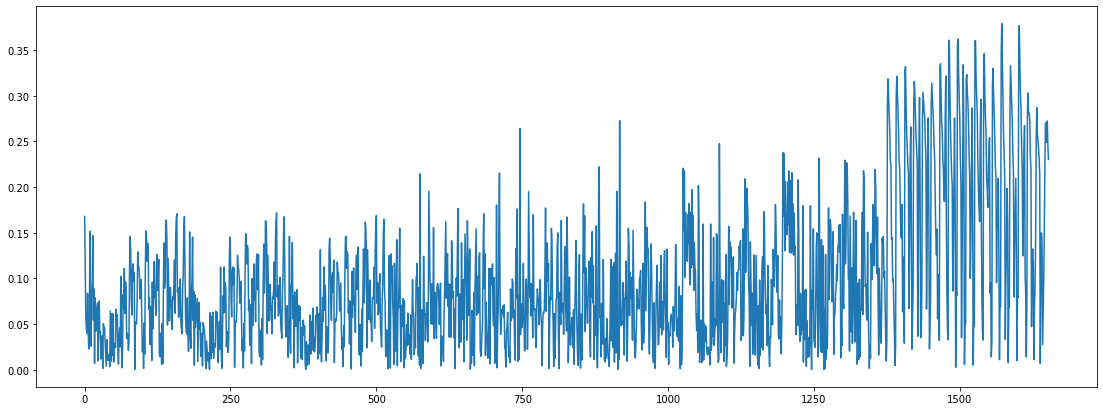

In [113]:
plt.figure(figsize=(19, 7))
plt.plot(df_y_corr['id'], df_y_corr['y'])
plt.show()

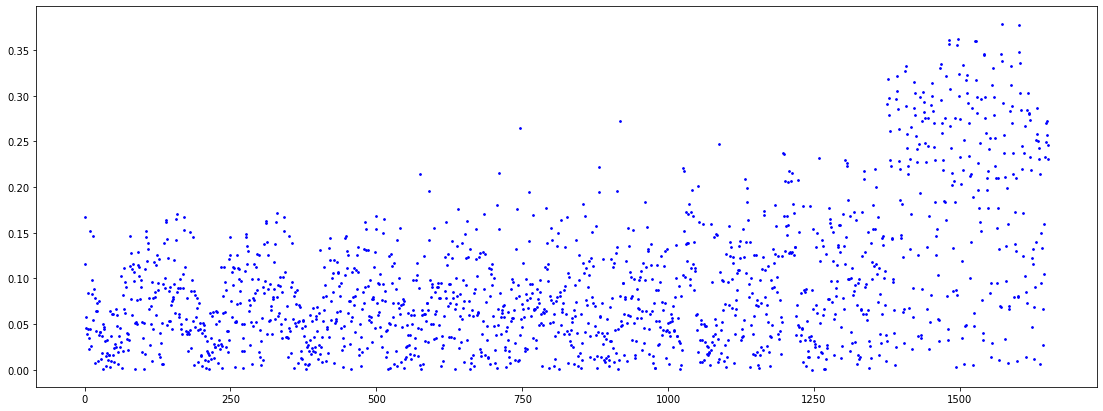

In [114]:
plt.figure(figsize=(19, 7))
plt.scatter(df_y_corr['id'], df_y_corr['y'], label='scatter', color='b', s=3)
plt.show()

testowanie czy wybranie 100 cech polepszy model

In [115]:
df_y_corr_100=df_y_corr['y'].sort_values(ascending=False)[:100]

In [116]:
df_y_corr_100=pd.DataFrame(df_y_corr_100)

In [117]:
df_y_corr_100.index

Index([1572, 1602, 1497, 1482, 1527, 1526, 1481, 1496, 1601, 1542, 1571, 1541,
       1573, 1603, 1467, 1506, 1587, 1407, 1466, 1557, 1406, 1498, 1512, 1476,
       1392, 1377, 1511, 1528, 1422, 1452, 1556, 1588, 1483, 1393, 1437, 1423,
       1617, 1513, 1604, 1499, 1453, 1558, 1529, 1543, 1431, 1378, 1391, 1536,
       1468, 1438, 1514, 1574, 1376, 1451, 1589, 1408, 1632, 1521, 1421, 1394,
       1616, 1605, 1454, 1586, 1439, 1530, 1619, 1618, 1379, 1424, 1559, 1544,
       1446, 1440, 1491, 1475, 1500, 1620, 1436,  917, 1650, 1590, 1469, 1647,
       1455, 1515, 1611, 1484, 1416,  746, 1395, 1380, 1545, 1470, 1633, 1409,
       1575, 1649, 1425, 1551],
      dtype='object')

In [118]:
df_X_train_y_new=df_X_train_y[[1572, 1602, 1497, 1482, 1527, 1526, 1481, 1496, 1601, 1542, 1571, 1541,
       1573, 1603, 1467, 1506, 1587, 1407, 1466, 1557, 1406, 1498, 1512, 1476,
       1392, 1377, 1511, 1528, 1422, 1452, 1556, 1588, 1483, 1393, 1437, 1423,
       1617, 1513, 1604, 1499, 1453, 1558, 1529, 1543, 1431, 1378, 1391, 1536,
       1468, 1438, 1514, 1574, 1376, 1451, 1589, 1408, 1632, 1521, 1421, 1394,
       1616, 1605, 1454, 1586, 1439, 1530, 1619, 1618, 1379, 1424, 1559, 1544,
       1446, 1440, 1491, 1475, 1500, 1620, 1436,  917, 1650, 1590, 1469, 1647,
       1455, 1515, 1611, 1484, 1416,  746, 1395, 1380, 1545, 1470, 1633, 1409,
       1575, 1649, 1425, 1551, 'y']]

In [119]:
y=df_X_train_y_new['y']

In [120]:
y.shape

(15092,)

In [121]:
X = df_X_train_y_new.drop(['y'], axis=1)

In [122]:
X.shape

(15092, 100)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

In [124]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (10564, 100) (10564,)
Test: (4528, 100) (4528,)


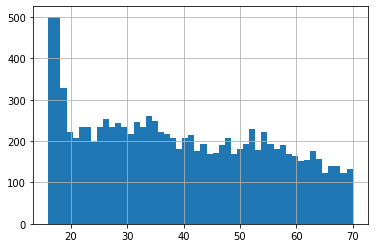

In [125]:
y_train.hist(bins=50);

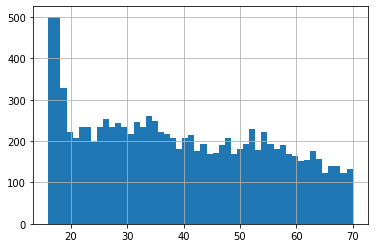

In [126]:
y_train.hist(bins=50);

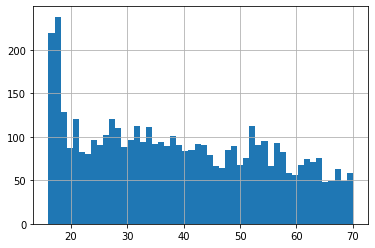

In [127]:
y_test.hist(bins=50);

In [128]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train,y_train)

DecisionTreeRegressor()

In [131]:
# Testing Data Evaluation
y_pred = dt_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 290.52547400112394
RMSE : 17.044807831158554
MAE : 12.8716898489103
R-Squared : -0.1861172629968073


In [132]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [133]:
# Testing Data Evaluation
y_pred = xgb_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE :",mse)

rmse = np.sqrt(mse)
print("RMSE :",rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE :",mae)

r2 = r2_score(y_test, y_pred)
print('R-Squared :',r2)

MSE : 141.81905856382707
RMSE : 11.908780733720269
MAE : 9.371111577656947
R-Squared : 0.4210007430058965


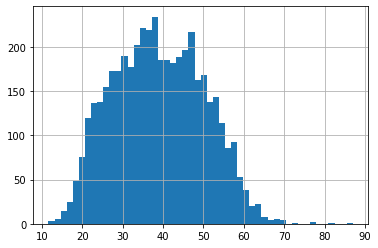

In [134]:
pd.Series(y_pred).hist(bins=50);

## Sprawdzenie PCA - czy poprawi wynik modelu

In [135]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

In [136]:
# https://github.com/MamczurMiroslaw/PCA/blob/master/notebooks/PCA_example.ipynb
# https://miroslawmamczur.pl/na-czym-polega-analiza-skladowych-glownych-pca/

In [137]:
df_X_train_id=df_X_train

In [138]:
df_X_train_id['id']=[x for x in range(len(df_X_train_id))]

In [139]:
df_X_train_id.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1645,1646,1647,1648,1649,1650,1651,1652,y,id
0,0.948392,0.807233,0.634927,0.795152,0.689951,0.808429,0.360581,0.324411,0.274222,0.485078,...,0.045557,0.045326,0.062304,0.065491,0.038242,0.014110,0.018287,0.013729,38.083333,0
1,0.746620,0.575926,0.214289,0.517099,0.307934,0.401059,0.521206,0.516610,0.191877,0.430831,...,0.016015,0.011243,0.011759,0.008217,0.004201,0.002672,0.003413,0.002757,44.833333,1
2,0.263161,0.330337,0.204795,0.338505,0.189303,0.249672,0.302185,0.193063,0.155043,0.248955,...,0.149967,0.050630,0.037759,0.033869,0.030550,0.022065,0.024785,0.018057,37.666667,2


In [140]:
# kolumny do wykluczenia (te na których nie chcemy PCA)
exclude_filter = ~df_X_train_id.columns.isin(['id']) 
# liczba głównych składowych
pca = PCA(n_components = 3)
# przeliczenie
principal_components = pca.fit_transform(df_X_train_id.loc[:, exclude_filter])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [141]:
principal_df = pd.DataFrame(data = principal_components, 
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principal_df['id'] = df_X_train_id['id']
principal_df

,principal component 1,principal component 2,principal component 3,id
0,-1.179466,1.637534,3.962036,0
1,5.632722,-1.179375,2.976190,1
2,-1.485577,-4.341022,0.750782,2
3,19.011166,2.567863,-1.994120,3
4,13.906169,0.098795,-1.923305,4
...,...,...,...,...
15087,19.461451,-0.150904,-0.206712,15087
15088,-21.689211,-2.319554,0.088699,15088
15089,11.440626,1.872752,0.744701,15089
15090,13.008310,0.161006,-0.788371,15090
